In [16]:
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from catboost import CatBoostClassifier

In [17]:
data = pd.read_csv('data/train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [18]:
class DataCleaner:
    def __init__(self):
        self.columns_to_drop = ['Ticket', 'Cabin', 'Name', 'PassengerId']
    
    def transform(self, data):
        data = data.drop(self.columns_to_drop, axis=1, errors='ignore')
        data = data.dropna()
        return data
    
    def fit(self):
        return self

In [19]:
cleaner = DataCleaner()
data = cleaner.transform(data)
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
885,0,3,female,39.0,0,5,29.1250,Q
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
889,1,1,male,26.0,0,0,30.0000,C


In [20]:
train_data = data.drop('Survived', axis=1)
train_labels = data[['Survived']]
train_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [21]:
class SimplePreprocesser:
    def __init__(self):
        self.column_transformer = ColumnTransformer(
            [
                ('ohe_encoder', OneHotEncoder(drop='first'), ['Pclass', 'Sex', 'Embarked'])
            ],
            sparse_threshold=0,
            remainder='passthrough'
        )
        self.columns_to_drop = ['Ticket', 'Cabin', 'Name']
    
    def fit(self, data):
        data = self._process_siblings(data)
        self.column_transformer.fit(data)
        return self
    
    def transform(self, data):
        data = self._process_siblings(data)
        return self.column_transformer.transform(data)
    
    @staticmethod
    def _process_siblings(data):
        data['Siblings'] = data['SibSp'] + data['Parch']
        return data.drop(['SibSp', 'Parch'], axis=1)

In [22]:
processor = SimplePreprocesser()
processor.fit(train_data)
train_data = processor.transform(train_data)
train_data

array([[ 0.    ,  1.    ,  1.    , ..., 22.    ,  7.25  ,  1.    ],
       [ 0.    ,  0.    ,  0.    , ..., 38.    , 71.2833,  1.    ],
       [ 0.    ,  1.    ,  0.    , ..., 26.    ,  7.925 ,  0.    ],
       ...,
       [ 0.    ,  0.    ,  0.    , ..., 19.    , 30.    ,  0.    ],
       [ 0.    ,  0.    ,  1.    , ..., 26.    , 30.    ,  0.    ],
       [ 0.    ,  1.    ,  1.    , ..., 32.    ,  7.75  ,  0.    ]])

In [23]:
model = CatBoostClassifier()
model.fit(train_data, train_labels)

Learning rate set to 0.008911
0:	learn: 0.6864150	total: 728us	remaining: 727ms
1:	learn: 0.6811622	total: 1.36ms	remaining: 681ms
2:	learn: 0.6746407	total: 2ms	remaining: 664ms
3:	learn: 0.6684808	total: 2.74ms	remaining: 682ms
4:	learn: 0.6628024	total: 3.35ms	remaining: 667ms
5:	learn: 0.6577628	total: 4.04ms	remaining: 669ms
6:	learn: 0.6521753	total: 4.57ms	remaining: 648ms
7:	learn: 0.6467119	total: 5.21ms	remaining: 646ms
8:	learn: 0.6413458	total: 5.83ms	remaining: 642ms
9:	learn: 0.6356450	total: 6.5ms	remaining: 643ms
10:	learn: 0.6312979	total: 6.93ms	remaining: 623ms
11:	learn: 0.6271168	total: 7.58ms	remaining: 624ms
12:	learn: 0.6222351	total: 8.17ms	remaining: 620ms
13:	learn: 0.6177762	total: 8.79ms	remaining: 619ms
14:	learn: 0.6129599	total: 9.37ms	remaining: 615ms
15:	learn: 0.6086058	total: 9.98ms	remaining: 614ms
16:	learn: 0.6036322	total: 10.6ms	remaining: 614ms
17:	learn: 0.5987912	total: 11.2ms	remaining: 611ms
18:	learn: 0.5952967	total: 11.7ms	remaining: 602

<Axes: >

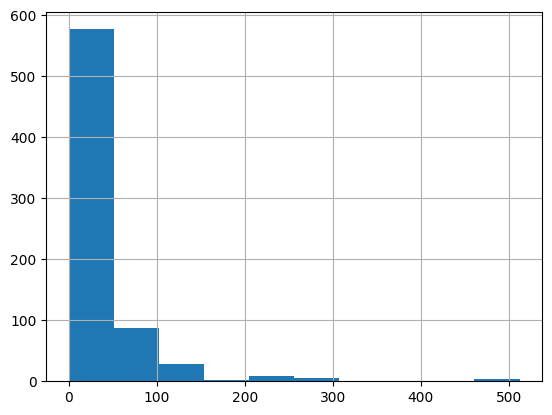

In [24]:
data['Fare'].hist()

In [25]:
data_entry = pd.DataFrame({
    'Pclass': [1],
    'Sex': 'male',
    'Age': 23,
    'SibSp': 0,
    'Parch': 0,
    'Fare': 300,
    'Embarked': 'S'
})
data_entry

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,male,23,0,0,300,S


In [26]:
processed_string = processor.transform(cleaner.transform(data_entry))

In [40]:
prediction = model.predict_proba(processed_string)[:, 0] * 100
print(f'Dead with probability of {prediction[0]:.2f}%.')

Dead with probability of 77.31%.


## Sample to test API

In [5]:
import requests

url = 'http://127.0.0.1:8000/predict'

data = {
    "PassengerId": 0,
    "Pclass": 3,
    "Name": 'Alex Morgan',
    "Sex": "male",
    "Age": 22,
    "SibSp": 1,
    "Parch": 0,
    'Ticket': 'BX322',
    "Fare": 7.25,
    'Cabin': '32S',
    "Embarked": "S"
}

response = requests.post(url, json=data)

print(response.text)

{"death_proba":0.887758364357552,"survive_proba":0.11224163564244799,"binary_prediction":0}
